In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from keras import layers, Sequential
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from keras.initializers import GlorotUniform, HeUniform, HeNormal
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
!pip install tab2img -q # q for quiet
from tab2img.converter import Tab2Img
seed = 314159
np.random.seed(seed)
tf.random.set_seed(seed)

ERROR: Invalid requirement: '#'

[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf

from keras.datasets import cifar10, mnist
from keras.optimizers.legacy import SGD, Adam
from keras.utils import to_categorical
from keras.backend import image_data_format
from keras.applications.mobilenet import MobileNet
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Reshape
from keras.layers import Dense, Dropout, BatchNormalization


import matplotlib.pyplot as plt
import numpy as np
import copy

import csv
import random
import time

# Importing necessary libraries for preprocessing and modeling
import numpy as np
import pandas as pd
import warnings
from sklearn.preprocessing import RobustScaler, StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Dropout


In [3]:
def sample_data(df, sample_fraction=0.1):
    sampled_df = df.groupby('Label').apply(lambda x: x.sample(frac=sample_fraction)).reset_index(drop=True)
    return sampled_df

In [4]:
df_data_1 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/Benign-Monday-no-metadata.parquet'))
df_data_2 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/Botnet-Friday-no-metadata.parquet'))
df_data_3 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/Bruteforce-Tuesday-no-metadata.parquet'))
df_data_4 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/DDoS-Friday-no-metadata.parquet'))
df_data_5 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/DoS-Wednesday-no-metadata.parquet'))
df_data_6 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/Infiltration-Thursday-no-metadata.parquet'))
df_data_7 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/Portscan-Friday-no-metadata.parquet'))
df_data_8 = sample_data(pd.read_parquet('C:/Users/Mo-gh/Desktop/New folder/WebAttacks-Thursday-no-metadata.parquet'))

df_data = pd.concat([df_data_1, df_data_2, df_data_3, df_data_4,
                     df_data_5, df_data_6, df_data_7, df_data_8], axis=0, ignore_index=True)


C:\Users\Mo-gh\AppData\Local\Temp\ipykernel_1124\2738659305.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  sampled_df = df.groupby('Label').apply(lambda x: x.sample(frac=sample_fraction)).reset_index(drop=True)
C:\Users\Mo-gh\AppData\Local\Temp\ipykernel_1124\2738659305.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby('Label').apply(lambda x: x.sample(frac=sample_fraction)).reset_index(drop=True)
C:\Users\Mo-gh\AppData\Local\Temp\ipykernel_1124\2738659305.py:2: FutureWarning: 

In [5]:
# Find and handle null values
null_counts = df_data.isnull().sum()
# Print the number of null values
print(f"{null_counts.sum()} null entries have been found in the dataset\n")
# Drop null values
df_data.dropna(inplace=True)          # or df_data = df_data.dropna()

# Find and handle duplicates
duplicate_count = df_data.duplicated().sum()
# Print the number of duplicate entries
print(f"{duplicate_count} duplicate entries have been found in the dataset\n")
# Remove duplicates
df_data.drop_duplicates(inplace=True)  # or df_data = df_data.drop_duplicates()
# Display relative message
print(f"All duplicates have been removed\n")

# Reset the indexes
df_data.reset_index(drop=True, inplace=True)

# Inspect the dataset for categorical columns
print("Categorical columns:",df_data.select_dtypes(include=['object']).columns.tolist(),'\n')

0 null entries have been found in the dataset

1299 duplicate entries have been found in the dataset

All duplicates have been removed

Categorical columns: ['Label'] 



In [6]:
print('Shape of Dataframe: ',df_data.shape,'\n')
print('Inspection of Target Feature - y:\n')
df_data.Label.value_counts()

Shape of Dataframe:  (230083, 78) 

Inspection of Target Feature - y:



Label
Benign                        196433
DoS Hulk                       17285
DDoS                           12801
DoS GoldenEye                   1029
FTP-Patator                      593
DoS slowloris                    538
DoS Slowhttptest                 523
SSH-Patator                      322
PortScan                         196
Web Attack � Brute Force         147
Bot                              144
Web Attack � XSS                  65
Infiltration                       4
Web Attack � Sql Injection         2
Heartbleed                         1
Name: count, dtype: int64

In [7]:
null_counts = df_data.isnull().sum()
df_data.dropna(inplace=True)
duplicate_count = df_data.duplicated().sum()
df_data.drop_duplicates(inplace=True)
df_data.reset_index(drop=True, inplace=True)
X = df_data.copy()
X = df_data.drop('Label', axis=1)
y = df_data['Label']
y = y.astype(str)
y = y.replace({
    'Benign': 0,
    'DoS Hulk': 2,
    'PortScan': 4,
    'DDoS': 2,
    'DoS GoldenEye': 2,
    'DoS slowloris': 2,
    'DoS Slowhttptest': 2,
    'Bot': 1,
    'Infiltration': 3,
    'Heartbleed': 2,
    'FTP-Patator': 5,
    'SSH-Patator': 5,
    'Web Attack � Brute Force': 6,  # Adjusted class name
    'Web Attack � XSS': 6,          # Adjusted class name
    'Web Attack � Sql Injection': 6  # Adjusted class name
})

# label_encoder = LabelEncoder()
# y_encoded = label_encoder.fit_transform(y)
y = pd.Series(y)
class_counts = y.value_counts()
class_ratios = class_counts / len(y)

# y = to_categorical(y)

C:\Users\Mo-gh\AppData\Local\Temp\ipykernel_1124\3261329185.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  y = y.replace({


In [8]:
# Set seed
seed_pi = 314159

# Set numpy seed
np.random.seed(seed_pi)
# Set the seed for TensorFlow
tf.random.set_seed(seed_pi)

In [9]:
def extractAllSets(X,y,p_train,p_val,p_test,random_state=seed_pi,shuffle=True):
    ''''
    Splits a given pandas dataframe X (features) into three subsets:X_train, X_val and X_test.
    Also splits a given pandas series y (target) to y_train, y_val and y_test respectively.
    Fractional ratios are provided by the user, as percentages, namely: p_train, p_valid, p_test.
    These inputs describe the percentage of the extracted sets in reference with the inputs X and y.
    The final sets are extracted by executing method train_test_split() twice.

    Parameters
    ----------
    X: pandas Dataframe
    y: pandas Series
    p_train, p_val, p_test  : float
    random_state : integer
    shuffle: (boolean) Enables shuffling the dataset

    The values should be expressed as float fractions and  should  sum to 1.0.
    The parameter of random_state ensures reproducibility.

    Returns
    -------
    X_train, X_val, X_test :
        Dataframes (features) containing the three splits.
    y_train, y_val, y_test  :
        Series (targets) containig the three splits
    '''
    # The initial train-test split produces X_train and y_train
    # Two additional sets are created X_temp and y_temp, that will produce the rest of the sets
    X_train, X_temp, y_train, y_temp = train_test_split(X,y, stratify=y,
        test_size=(1.0 - p_train), random_state=random_state, shuffle=shuffle)
                                                                        # Enable/desable shuffling
    # Note that by applying the stratify condition we ensure homogeneous distribution
    # of chareacteristics in targets

    # Parameter fraction describes the relevant size of the test size
    fraction = p_test / (p_val + p_test)
    X_val, X_test, y_val, y_test = train_test_split(X_temp,y_temp,stratify=y_temp,
        test_size=fraction, random_state=random_state, shuffle=shuffle) # Enable/desable shuffling
    # Note that we use the same random_state twice for reproducibility

    return X_train, X_val, X_test, y_train, y_val, y_test

In [13]:
X_train, X_val, X_test, y_train, y_val, y_test = extractAllSets(X, y, 0.55, 0.1, 0.35)

# Organize all sets in list format
original_data = [X_train, X_val, X_test, y_train, y_val, y_test]

In [14]:
# Initialize QuantileTransformer with uniform distribution
quantile_transformer = QuantileTransformer(n_quantiles=10**4, output_distribution='uniform')

# Fit and transform the training data
X_train_transformed = quantile_transformer.fit_transform(X_train)

# Transform the validation and test data using the same transformer
X_val_transformed  = quantile_transformer.transform(X_val)
X_test_transformed = quantile_transformer.transform(X_test)

# Arrange transformed data as a list
scaled_data = [X_train_transformed, X_val_transformed, X_test_transformed, y_train, y_val, y_test]

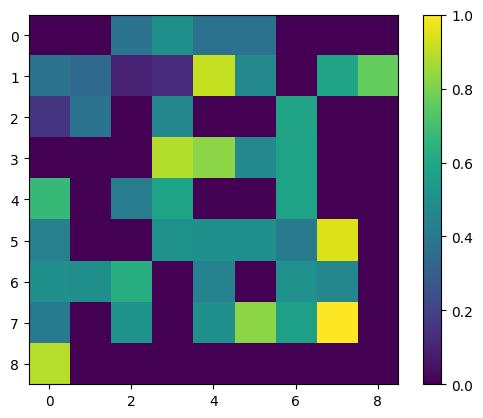

In [15]:
# Define the Tab2Img model
model_tab2img = Tab2Img()

""" In this stage, every sample in the data becomes a (9x9) numpy array. """
# Convert training data
X_train_images = model_tab2img.fit_transform(X_train_transformed, y_train.values)

# Convert validation and test data (using the fitted model)
X_val_images  = model_tab2img.transform(X_val_transformed)
X_test_images = model_tab2img.transform(X_test_transformed)

""" In this stage, every array in the data becomes a (9x9x1) greyscale image. """
# Greyscale Transformation - Reshape the image data for CNN input
X_train_images = X_train_images.reshape(-1, 9, 9, 1)
X_val_images   = X_val_images.reshape(  -1, 9, 9, 1)
X_test_images  = X_test_images.reshape( -1, 9, 9, 1)

# Visualize an example
plt.imshow(X_train_images[0])
plt.colorbar()
plt.show()

In [16]:
import numpy as np
X_train_images = np.array(X_train_images)
X_val_images = np.array(X_val_images)
X_test_images = np.array(X_test_images)
Y_train = np.array(y_train)
Y_val = np.array(y_val)
Y_test_test = np.array(y_test)

In [17]:
X_train_images.shape, Y_train.shape, X_val_images.shape, Y_val.shape, X_test_images.shape, Y_test_test.shape

((126545, 9, 9, 1),
 (126545,),
 (23008, 9, 9, 1),
 (23008,),
 (80530, 9, 9, 1),
 (80530,))

In [18]:
from keras.layers import Dense, GRU, Flatten, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras import regularizers
from tensorflow.keras.regularizers import l2

# input_shape = (9,9,1)
num_classes = 7
class CustomModel:
    def __init__(self, loss, optimizer, num_classes):
        self.loss = loss
        self.optimizer = optimizer
        self.num_classes = num_classes

    def fl_paper_model(self,train_shape):

          conv_initializer   = HeNormal(seed=seed_pi)
          dense_initializer  = HeUniform(seed=seed_pi)
          output_initializer = GlorotUniform(seed=seed_pi)
          mlp = Sequential([
          Input(shape=(9, 9, 1)),

          Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer=conv_initializer),
          MaxPooling2D(pool_size=(2, 2)),
          Flatten(),
          Dense(128, activation='relu', kernel_initializer=dense_initializer),
          BatchNormalization(),
          Dense(num_classes, activation='softmax', kernel_initializer=output_initializer)
      ])
          mlp.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
          return mlp

In [ ]:
# Global configuration
from tensorflow.keras.optimizers import SGD, Adam
NUMOFCLIENTS = 10 # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5 # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.5
LOCAL_ACC = 0.9
GLOBAL_ACC = 1.1
DROP_RATE = 0
# Model configuration
# LOSS = 'binary_crossentropy'
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 7
lr = 0.00001
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(x_train, y_train, num_clients):

    num_partitions = 10
    # Ensure dataset is numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Step 1: Create partitions based on class labels
    class_indices = {}
    for i, label in enumerate(y_train):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    partitions = []
    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        partitions.extend(np.array_split(indices, num_partitions))

    np.random.shuffle(partitions)

    # Step 2: Assign each client 2 partitions randomly
    client_data_indices = {i: [] for i in range(num_clients)}
    for i in range(num_clients):
        selected_partitions = np.random.choice(len(partitions), 4, replace=False)
        for partition_idx in selected_partitions:
            client_data_indices[i].extend(partitions[partition_idx])

    # Step 3: Gather data for each client
    client_data = []
    for i in range(num_clients):
        indices = client_data_indices[i]
        client_data.append((x_train[indices], y_train[indices]))

    return client_data

class particle():
    def __init__(self, particle_num, client, x_train, y_train):
        # for check particle id
        self.particle_id = particle_num

        # particle model init
        self.particle_model = client

        # best model init
        self.local_best_model = client
        self.global_best_model = client

        # best score init
        self.local_best_score = 0.0
        self.global_best_score = 0.0

        self.x = x_train
        self.y = y_train

        # acc = acceleration
        self.parm = {'acc':ACC, 'local_acc':LOCAL_ACC, 'global_acc':GLOBAL_ACC}

        # velocities init
        self.velocities = [None] * len(client.get_weights())
        for i, layer in enumerate(client.get_weights()):
            self.velocities[i] = np.random.rand(*layer.shape) / 5 - 0.10

    def train_particle(self):
        print("particle {}/{} fitting".format(self.particle_id+1, NUMOFCLIENTS))

        # set each epoch's weight
        step_model = self.particle_model
        step_weight = step_model.get_weights()

        # new_velocities = [None] * len(step_weight)
        new_weight = [None] * len(step_weight)
        local_rand, global_rand = random.random(), random.random()

        # PSO algorithm applied to weights
        for index, layer in enumerate(step_weight):
            new_v = self.parm['acc'] * self.velocities[index]
            new_v = new_v + self.parm['local_acc'] * local_rand * (self.local_best_model.get_weights()[index] - layer)
            new_v = new_v + self.parm['global_acc'] * global_rand * (self.global_best_model.get_weights()[index] - layer)
            self.velocities[index] = new_v
            new_weight[index] = step_weight[index] + self.velocities[index]

        optimizer = Adam(learning_rate=lr)
        step_model.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])

        step_model.set_weights(new_weight)

        # Recreate the optimizer to avoid the error

        # 4.2 - Early Stopping, Learning Rate Scheduler and Compiling
        # save_model_path = 'checkpoint/checkpoint_particle_{}.weights.h5'.format(self.particle_id)
        save_model_path = 'checkpoint_1/checkpoint_particle_{}.weights.h5'.format(self.particle_id)

        mc = ModelCheckpoint(filepath=save_model_path,
                            monitor='val_loss',
                            mode='min',
                            save_best_only=True,
                            save_weights_only=True)

        early_stopping = EarlyStopping(
            monitor='val_accuracy',
            patience=10,
            verbose=1,
            restore_best_weights=True)

        reduce_lr = ReduceLROnPlateau(
            monitor='val_accuracy',
            patience=5,
            min_lr=1e-07,
            verbose=1,
            factor=0.1)

        hist = step_model.fit(x=self.x, y=self.y,
                              epochs=CLIENT_EPOCHS,
                              batch_size=BATCH_SIZE,
                              verbose=1,
                              validation_split=0.1,
                              callbacks=[mc])

        train_score_loss = hist.history['val_loss'][-1]

        step_model.load_weights(save_model_path)
        self.particle_model = step_model

        if self.global_best_score >= train_score_loss:
            self.local_best_model = step_model

        return self.particle_id, train_score_loss

    def update_global_model(self, global_best_model, global_best_score):
        if self.local_best_score < global_best_score:
            self.global_best_model = global_best_model
            self.global_best_score = global_best_score

    def resp_best_model(self, gid):
        if self.particle_id == gid:
            return self.particle_model


def get_best_score_by_loss(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 100000
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score > result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]


def get_best_score_by_acc(step_result):
    # step_result = [[step_model, train_socre_acc],...]
    temp_score = 0
    temp_index = 0

    for index, result in enumerate(step_result):
        if temp_score < result[1]:
            temp_score = result[1]
            temp_index = index

    return step_result[temp_index][0], step_result[temp_index][1]

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)

    from collections import Counter
    for i in range(NUMOFCLIENTS):  # Iterate using indices
        x, y = client_data[i]  # Access data using index
        class_distribution = dict(Counter(y))
        print(f"Client {i+1} class distribution:")
        print(class_distribution)

    server_model = init_model(train_data_shape=train_data_shape)
    # print(server_model.summary())

    pso_model = []
    for i in range(NUMOFCLIENTS):
        pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i][0], y_train=client_data[i][1]))
        # pso_model.append(particle(particle_num=i, client=init_model(train_data_shape = x_train[0].shape[1]), x_train=client_data[i+1]['X_train_images'], y_train=client_data[i+1]['Y_train']))


    server_evaluate_acc = []
    global_best_model = None
    global_best_score = 0.0

    for epoch in range(EPOCHS):
        server_result = []
        start = time.time()

        for client in pso_model:
            if epoch != 0:
                client.update_global_model(server_model, global_best_score)

            pid, train_score = client.train_particle()
            rand = random.randint(0, 99)

            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_result.append([pid, train_score])

        gid, global_best_score = get_best_score_by_loss(server_result)
        for client in pso_model:
            if client.resp_best_model(gid) != None:
                global_best_model = client.resp_best_model(gid)

        server_model = global_best_model

        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedPso_Custom_Function", server_evaluate_acc)

'''Confusion Matrix FedPso_Custom_Function:
[[121286,      5 ,   425 ,     0  ,    1  ,    0  ,    0],
 [    90 ,     0 ,     0 ,     0 ,     0  ,    0,      0],
 [   295,     0 , 19816,      0 ,     0   ,   0 ,     0],
 [     2,     0  ,    0 ,     0  ,    0  ,    0 ,     0],
 [   101 ,     0 ,    21 ,     0 ,     0  ,    0 ,     0],
 [   572  ,    0 ,     0 ,     0 ,     0   ,   0 ,     0],
 [   132 ,     0  ,    2 ,     0 ,     0   ,   0,      0]]'''


Shape of a single data point: (9,)
Client 1 class distribution:
{5: 148, 0: 31647, 2: 10458}
Client 2 class distribution:
{0: 31646, 5: 148, 1: 23, 2: 5229}
Client 3 class distribution:
{2: 5229, 0: 31646, 5: 149, 3: 1}
Client 4 class distribution:
{2: 10458, 5: 149, 3: 1}
Client 5 class distribution:
{2: 5229, 6: 35, 4: 63}
Client 6 class distribution:
{5: 298, 1: 23}
Client 7 class distribution:
{2: 5229, 5: 298, 0: 31646}
Client 8 class distribution:
{2: 10458, 1: 23, 0: 31646}
Client 9 class distribution:
{4: 64, 2: 5229, 0: 31646}
Client 10 class distribution:
{3: 1, 1: 70}
particle 1/10 fitting
Epoch 1/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 5s 12ms/step - accuracy: 0.0796 - loss: 2.5135 - val_accuracy: 0.1671 - val_loss: 1.8803
Epoch 2/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1428 - loss: 2.0499 - val_accuracy: 0.4115 - val_loss: 1.6099
Epoch 3/5
149/149 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.2431 - loss: 1.8084 - val_accuracy: 0.6827 - val_loss: 1.2361
Epoch 4/

4461/4461 ━━━━━━━━━━━━━━━━━━━━ 21s 5ms/step
Confusion Matrix:
[[121286      5    425      0      1      0      0]
 [    90      0      0      0      0      0      0]
 [   295      0  19816      0      0      0      0]
 [     2      0      0      0      0      0      0]
 [   101      0     21      0      0      0      0]
 [   572      0      0      0      0      0      0]
 [   132      0      2      0      0      0      0]]


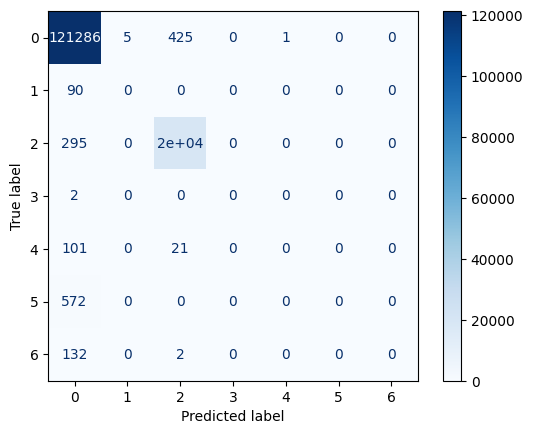

In [24]:
# Predict on the test set
# 
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

Shape of a single data point: (9,)
Client 1 class distribution:
{1: 8, 5: 51, 3: 1, 6: 12, 0: 10804}
Client 2 class distribution:
{0: 10803, 1: 23, 2: 1769, 4: 11, 5: 51}
Client 3 class distribution:
{3: 1, 6: 12, 0: 21607, 2: 3540}
Client 4 class distribution:
{4: 22, 3: 1, 2: 1770, 5: 50, 6: 12}
Client 5 class distribution:
{3: 1, 4: 22, 5: 101, 0: 10804}
Client 6 class distribution:
{6: 12, 1: 16, 2: 1770, 4: 11}
Client 7 class distribution:
{2: 3540, 6: 12, 5: 101, 0: 10804}
Client 8 class distribution:
{4: 11, 1: 16, 0: 21607, 5: 50}
Client 9 class distribution:
{2: 1770, 0: 32412, 4: 11, 1: 7}
Client 10 class distribution:
{0: 21608, 2: 3540, 6: 12, 1: 8}
client 1/10 fitting
Epoch 1/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6239 - loss: 1.3498 - val_accuracy: 0.9609 - val_loss: 0.7038
Epoch 2/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9829 - loss: 0.1554 - val_accuracy: 0.9617 - val_loss: 0.2995
Epoch 3/5
79/79 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accura

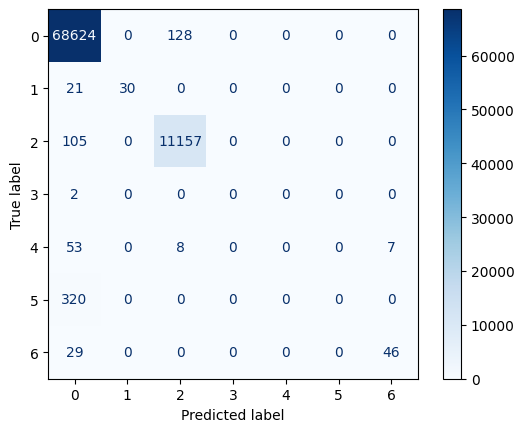

In [19]:
# Global configuration
from tensorflow.keras.optimizers import Adam, SGD

# Global configuration
NUMOFCLIENTS = 10  # number of clients (particles)
EPOCHS = 30  # number of total iterations
CLIENT_EPOCHS = 5  # number of each client's iterations
BATCH_SIZE = 256 # Size of batches to train on
ACC = 0.4
LOCAL_ACC = 0.8
GLOBAL_ACC = 1.4
DROP_RATE = 0
SELECT_CLIENTS = 1
# Model configuration
LOSS = 'sparse_categorical_crossentropy'
NUMOFCLASSES = 7
lr = 0.00001
# lr = 0.001
OPTIMIZER = Adam(learning_rate=lr)
# OPTIMIZER = SGD(learning_rate=lr, momentum=0.9, nesterov=False)

# Function to write results to CSV
def write_csv(algorithm_name, list):
    file_name = '{name}_10Clients_{drop}%_output_LR_{lr}_CLI_{cli}_CLI_EPOCHS_{cli_epoch}_TOTAL_EPOCHS_{epochs}_BATCH_{batch}.csv'
    file_name = file_name.format(drop=DROP_RATE, name=algorithm_name, lr=lr, cli=NUMOFCLIENTS, cli_epoch=CLIENT_EPOCHS, epochs=EPOCHS, batch=BATCH_SIZE)
    f = open(file_name, 'w', encoding='utf-8', newline='')
    wr = csv.writer(f)

    for l in list:
        wr.writerow(l)
    f.close()

def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model


def init_model(train_data_shape):
    model = CustomModel(loss=LOSS, optimizer=OPTIMIZER,num_classes=NUMOFCLASSES)
    init_model = model.fl_paper_model(train_shape=train_data_shape)

    return init_model

def client_data_config(x_train, y_train, num_clients):

    num_partitions = 10
    # Ensure dataset is numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    # Step 1: Create partitions based on class labels
    class_indices = {}
    for i, label in enumerate(y_train):
        if label not in class_indices:
            class_indices[label] = []
        class_indices[label].append(i)

    partitions = []
    for label, indices in class_indices.items():
        np.random.shuffle(indices)
        partitions.extend(np.array_split(indices, num_partitions))

    np.random.shuffle(partitions)

    # Step 2: Assign each client 2 partitions randomly
    client_data_indices = {i: [] for i in range(num_clients)}
    for i in range(num_clients):
        selected_partitions = np.random.choice(len(partitions), 7, replace=False)
        for partition_idx in selected_partitions:
            client_data_indices[i].extend(partitions[partition_idx])

    # Step 3: Gather data for each client
    client_data = []
    for i in range(num_clients):
        indices = client_data_indices[i]
        client_data.append((x_train[indices], y_train[indices]))

    return client_data


def fedAVG(server_weight):
    avg_weight = [np.zeros_like(w) for w in server_weight[0]]  # Initialize with the same structure as the first set of weights

    for client_weights in server_weight:
        for i, w in enumerate(client_weights):
            avg_weight[i] += w

    avg_weight = [w / len(server_weight) for w in avg_weight]  # Compute the average

    return avg_weight

def client_update(index, client, now_epoch, avg_weight):
    print("client {}/{} fitting".format(index + 1, int(NUMOFCLIENTS * SELECT_CLIENTS)))

    optimizer = tf.keras.optimizers.Adam()
    client.compile(optimizer=optimizer, loss=LOSS, metrics=['accuracy'])
    if now_epoch != 0:
        client.set_weights(avg_weight)

    client.fit(client_data[i][0], client_data[i][1],
        epochs=CLIENT_EPOCHS,
        batch_size=BATCH_SIZE,
        verbose=1,
        validation_split=0.2,
    )

    return client

if __name__ == "__main__":

    x_train = X_train_images
    y_train = Y_train
    x_test = X_test_images
    y_test = Y_test_test

    train_data_shape = (x_train[0].shape[1],)
    print("Shape of a single data point:", train_data_shape)
    client_data = client_data_config(x_train, y_train, NUMOFCLIENTS)
    server_model = init_model(train_data_shape=train_data_shape)

    from collections import Counter
    for i in range(NUMOFCLIENTS):  # Iterate using indices
        x, y = client_data[i]  # Access data using index
        class_distribution = dict(Counter(y))
        print(f"Client {i+1} class distribution:")
        print(class_distribution)

    fl_model = []
    for i in range(NUMOFCLIENTS):  # Keys are now starting from 0
        fl_model.append(init_model(train_data_shape=train_data_shape,))

    avg_weight = [np.zeros_like(w) for w in server_model.get_weights()]

    server_evaluate_acc = []

    for epoch in range(EPOCHS):
        server_weight = []

        selected_num = int(max(NUMOFCLIENTS * SELECT_CLIENTS, 1))
        split_data_index = []
        while len(split_data_index) < selected_num:
            item = random.choice(range(len(fl_model)))
            if item not in split_data_index:
                split_data_index.append(item)
        split_data_index.sort()
        selected_model = [fl_model[k] for k in split_data_index]

        for index, client in enumerate(selected_model):
            recv_model = client_update(index, client, epoch, avg_weight)

            rand = random.randint(0, 99)
            drop_communication = range(DROP_RATE)
            if rand not in drop_communication:
                server_weight.append(copy.deepcopy(recv_model.get_weights()))

        avg_weight = fedAVG(server_weight)

        server_model.set_weights(avg_weight)
        print("server {}/{} evaluate".format(epoch + 1, EPOCHS))
        server_evaluate_acc.append(server_model.evaluate(x_test, y_test, batch_size=BATCH_SIZE, verbose=1))

    write_csv("FedAvg_Custom_Function_CICIDS", server_evaluate_acc)

# Predict on the test set
# 
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

'''Confusion Matrix:
[[68624,     0,   128,     0,     0,     0 ,    0],
 [   21,    30,     0,     0,     0 ,    0,     0],
 [  105,     0, 11157,     0,     0 ,    0,     0],
 [    2,     0,     0 ,    0,     0 ,    0 ,    0],
 [   53,     0,     8,    0,     0  ,   0 ,    7],
 [  320,     0,     0,     0,     0 ,    0 ,    0],
 [   29,     0,     0 ,    0 ,    0 ,    0 ,   46]]'''

In [1]:
# Predict on the test set
# 
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = np.argmax(server_model.predict(x_test), axis=-1)

# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=np.arange(NUMOFCLASSES))

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally visualize the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(NUMOFCLASSES)])
disp.plot(cmap=plt.cm.Blues)
plt.show()

NameError: name 'server_model' is not defined